In [93]:
import pandas as pd
import numpy as np	
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
from matplotlib.patches import Wedge, Circle
from matplotlib.collections import PatchCollection

from geopack import geopack, t89
from spacepy import pycdf
import pyspedas
import pyspedas.geopack as pygeo

In [78]:
df = pd.read_feather('../../data/supermag/CMO.feather')
df = df.set_index('Date_UTC')
df.index = pd.to_datetime(df.index)
ace = pd.read_feather('../../data/SW/ace_data.feather')
print(ace.columns)
ace = ace.set_index('ACEepoch')
ace.index = pd.to_datetime(ace.index)

Index(['ACEepoch', 'B_Total', 'BY_GSM', 'BZ_GSM', 'Vx', 'Vy', 'Vz',
       'proton_density', 'T', 'Pressure', 'E_Field'],
      dtype='object')


In [177]:
def dual_half_circle(center=(0,0), radius=1, angle=90, ax=None, colors=('w','k','k'),
                     **kwargs):
    """
    Add two half circles to the axes *ax* (or the current axes) with the 
    specified facecolors *colors* rotated at *angle* (in degrees).
    """
    if ax is None:
        ax = plt.gca()
    theta1, theta2 = angle, angle + 180
    #w1 = Wedge(center, radius, theta1, theta2, fc=colors[0], **kwargs)
    #w2 = Wedge(center, radius, theta2, theta1, fc=colors[1], **kwargs)
    
    w1 = Wedge(center, radius, theta1, theta2, fc=colors[1], **kwargs)
    w2 = Wedge(center, radius, theta2, theta1, fc=colors[0], **kwargs)
   
    cr = Circle(center, radius, fc=colors[2], fill=False, **kwargs)
    for wedge in [w1, w2, cr]:
        ax.add_artist(wedge)
    return [w1, w2, cr]

def setup_fig(plotting_y=True, xlim=(10,-30),ylim=(-20,20)):

    fig = plt.figure(figsize=(15,10))
    ax  = fig.add_subplot(111)
    ax.axvline(0,ls=':',color='k')
    ax.axhline(0,ls=':',color='k')
    ax.set_xlabel('X GSM [Re]')
    if ylabel:
        ax.set_ylabel('Y GSM [Re]')
    else:
        ax.set_ylabel('Z GSM [Re]')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.invert_xaxis()

    
    ax.set_aspect('equal')
    w1,w2,cr = dual_half_circle(ax=ax)
    
    return ax

In [154]:
date = '2013-05-13 04:00:00'
t0 = datetime(1970,1,1)
t1 = parser.parse(date)
ut = (t1-t0).total_seconds()
print(ut)

vx = ace['Vx'][date]
vy = ace['Vy'][date]
vz = ace['Vz'][date]

ps = geopack.recalc(ut, vxgse=vx, vygse=vy, vzgse=vz)

1368417600.0


In [155]:
df.columns

Index(['GEOLON', 'GEOLAT', 'MAGLON', 'MLAT', 'MLT', 'SZA', 'N', 'E', 'Z',
       'dbn_geo', 'dbe_geo', 'dbz_geo', 'MAGNITUDE', 'dbht'],
      dtype='object')

In [164]:
# get station coordinates at datetime
# ott_lat = df['MLAT'][date]
# ott_lon = df['MAGLON'][date]
# ott_lon = ott_lon + 360 if ott_lon < 0 else ott_lon
# print(ott_lat, ott_lon)
ott_lat, ott_lon = 45.4, 284.45

# convert degrees to radians
lat_rad = np.deg2rad(ott_lat)
lon_rad = np.deg2rad(ott_lon)
print(lat_rad, lon_rad)

# Convert Geodetic to geocentric spherical
r, theta_rad = geopack.geodgeo(0, lat_rad, 1)
print(r, theta_rad, lon_rad)

# Converting Geocentric Spherical to Geocentric Cartesian
x_gc, y_gc, z_gc = geopack.sphcar(1, theta_rad, lon_rad, 1)
print('GC:  ', x_gc,y_gc,z_gc,' R=',np.sqrt(x_gc**2+y_gc**2+z_gc**2))

# Convert Geocentric Cartesian to GSM
x_gsm, y_gsm, z_gsm = geopack.geogsm(x_gc, y_gc, z_gc, 1)
print('GSM: ', x_gsm,y_gsm,z_gsm,' R=',np.sqrt(x_gsm**2+y_gsm**2+z_gsm**2))


0.7923794804054256 4.964589057297871
6367.340249429474 0.7817750951734465 4.964589057297871
GC:   0.1758074798373014 -0.6822526610537621 0.7096640307344857  R= 0.9999999999999999
GSM:  -0.4226559642677754 0.14726447780163204 0.8942455532160556  R= 0.9999999999999999


In [165]:
x, y, z, xx, yy, zz = geopack.trace(x_gsm, y_gsm, z_gsm, dir=1, rlim=1000, r0=.99999, parmod=2, exname='t89', inname='igrf', maxloop=10000)
print(x,y,z)
print(xx,yy,zz)

-0.61676835882614 0.1388737492637866 -0.7740155738538861
[-0.42265596 -0.42963302 -0.43665461 -0.44372024 -0.45082937 -0.4579815
 -0.46517616 -0.47241286 -0.47969113 -0.48701051 -0.49437055 -0.50177081
 -0.50921085 -0.51669025 -0.52420858 -0.53176543 -0.5393604  -0.54699309
 -0.5546631  -0.56237005 -0.57011354 -0.57789321 -0.58570867 -0.59355957
 -0.60144554 -0.60936621 -0.61732124 -0.62531027 -0.63333295 -0.64138895
 -0.64947791 -0.65759951 -0.6657534  -0.67393927 -0.68215678 -0.6904056
 -0.69868542 -0.70699591 -0.71533675 -0.72370764 -0.73210826 -0.7405383
 -0.74899745 -0.75748541 -0.76600187 -0.77454652 -0.78311908 -0.79171923
 -0.80034669 -0.80900115 -0.81768233 -0.82638992 -0.83512364 -0.8438832
 -0.85266831 -0.86147868 -0.87031402 -0.87917405 -0.88805849 -0.89696704
 -0.90589943 -0.91485537 -0.92383459 -0.9328368  -0.94186172 -0.95090907
 -0.95997857 -0.96906995 -0.97818292 -0.98731722 -0.99647255 -1.00564865
 -1.01484524 -1.02406204 -1.03329878 -1.04255517 -1.05183095 -1.0611258

ValueError: too many values to unpack (expected 2)

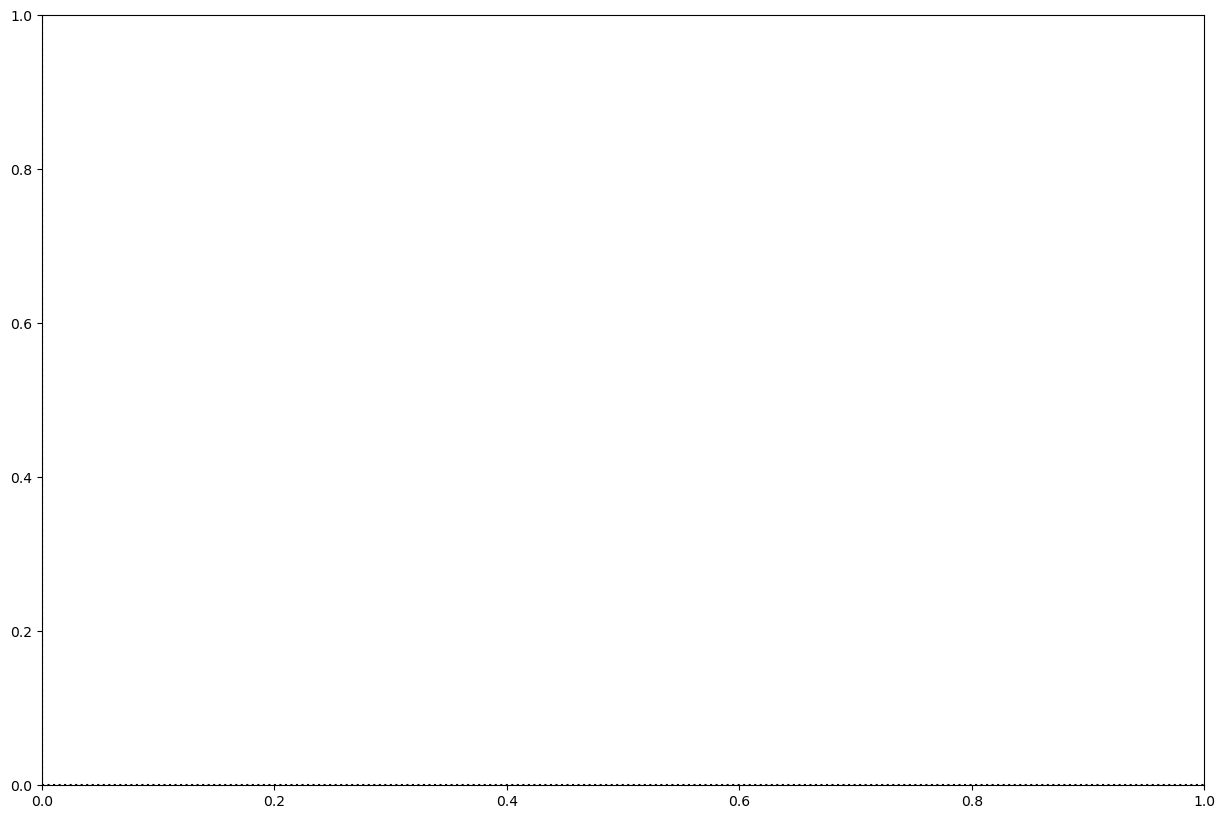

In [178]:
ax=setup_fig()
ax.plot(xx, yy)
plt.show()

In [101]:
ut = 100
xgsm,ygsm,zgsm = [1,2,3]
ps = geopack.recalc(ut)
b0xgsm,b0ygsm,b0zgsm = geopack.dip(x_gsm,y_gsm,z_gsm)    		# calc dipole B in GSM.
dbxgsm,dbygsm,dbzgsm = t89.t89(2, ps, x_gsm,y_gsm,z_gsm)       # calc T89 dB in GSM.
bxgsm,bygsm,bzgsm = [b0xgsm+dbxgsm,b0ygsm+dbygsm,b0zgsm+dbzgsm]
print(bxgsm,bygsm,bzgsm)
xx, yy, zz = [x_gsm+bxgsm, x_gsm], [y_gsm+bygsm, y_gsm], [z_gsm+bzgsm, z_gsm]

20728.593426175434 -18668.484872974885 -53816.536977917785


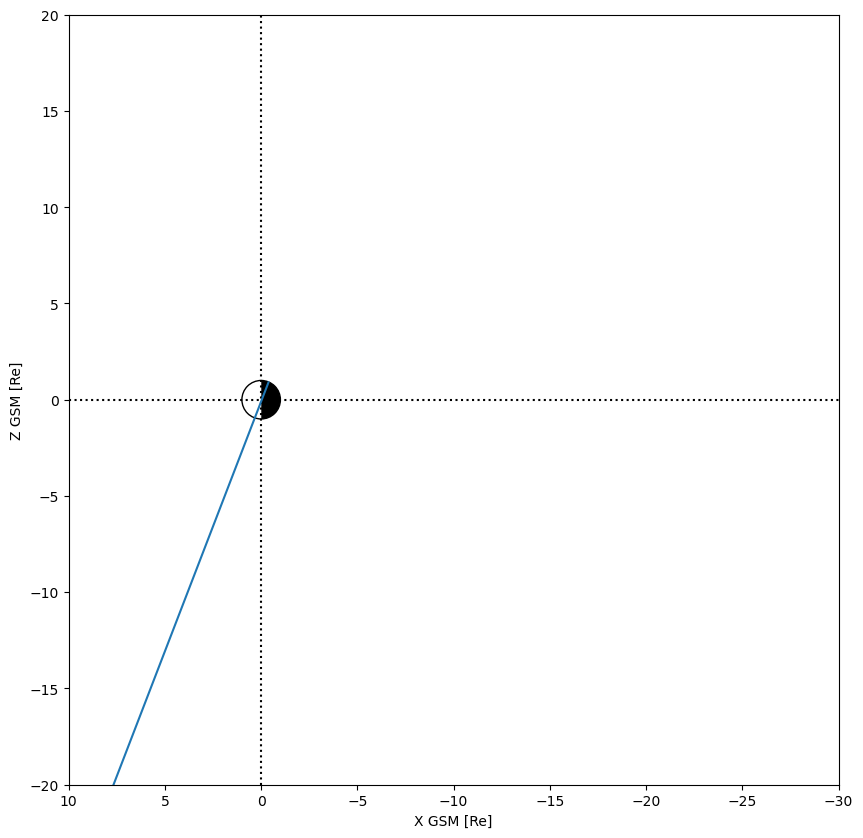

In [102]:
ax = setup_fig()
ax.plot(xx, zz)
plt.show()